# 1. Introduction to object detection

This notebook is motivated by fast.ai's course.

As an introduction to object detection, I will train a neural network which will find the largest object in the image, and draw a bounding box around it.

In [1]:
%matplotlib inline

In [2]:
import torch
import voc
from pathlib import Path

Pick one

In [3]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

1. Let's take a look at the data

Note that I haven't rearranged the data from when I downloaded it on the [VOC website](http://host.robots.ox.ac.uk/pascal/VOC/). I downloaded the 2007 dataset. 

Showing VOC2007/Annotations/002875.xml


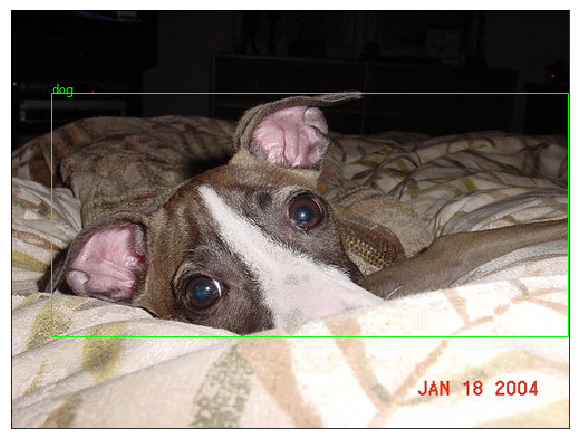

In [4]:
annotation = voc.utils.show_random_example(return_annotation=True)

For this exercise, we will only be recognizing the largest object in the image, so given the annotations, I want to find the largest object.

In [5]:
filtered = voc.utils.keep_largest_box(annotation)

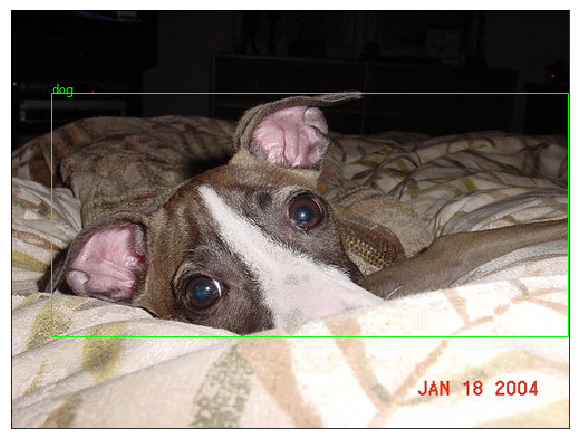

In [6]:
voc.utils.show_annotation(filtered)

Awesome. So now, I have annotations, and images. I want to turn these into iterables I can pass to a neural network.

In order to finetune the model, I want to remove the last few layers, and replace them with a 4 dimensional output which isn't put through a softmax (since this is no longer a classification problem).

In [27]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [8]:
total_dataset = voc.datasets.VOCDataset()

Now that we know the size of the dataset, we can use this to create a mask

In [9]:
train_mask = np.random.rand(len(total_dataset)) < 0.8
val_mask = ~train_mask

In [10]:
train_images = voc.datasets.ImageDataset(mask=train_mask, normalizer='imagenet', 
                                         random_transform=True, resize=(224, 224), device=device)

In [11]:
label2class = train_images.get_labels_from_classes()

In [12]:
val_images = voc.datasets.ImageDataset(mask=val_mask, normalizer='imagenet', resize=(224, 224),
                                       label2class=label2class, device=device)

In [13]:
train_dataloader = DataLoader(train_images, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_images, batch_size=128)

Optionally, add a `.cuda()` call if you are running stuff on a GPU.

In [14]:
sod = voc.models.SODNet(num_classes = len(label2class)).cuda()

In [16]:
loss_weight = voc.models.get_sod_weight(sod, next(iter(train_dataloader)))

In [17]:
loss_weight

0.04237585887312889

In [18]:
bb_criterion = torch.nn.modules.loss.L1Loss()
label_criterion = torch.nn.modules.loss.CrossEntropyLoss()

In [19]:
parameters_to_update = len([parameters for name, parameters in sod.named_parameters() if 'finetune' in name])

In [20]:
optimizer = torch.optim.Adam(list(sod.parameters())[:-parameters_to_update])

In [22]:
num_epochs = 3

In [29]:
for epoch in range(num_epochs):
    # set model to train
    sod.train()

    # Keep track of my loss, so I can display it
    running_train_scores = defaultdict(list)

    # Iterate through my batches
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = sod(ims)

        bb_loss = bb_criterion(output_bb, target_bb.float())
        label_loss = label_criterion(output_labels, target_label.long())

        loss = label_loss + (loss_weight * bb_loss)

        loss.backward()
        optimizer.step()
        # For display purposes:
        running_train_scores['bb'].append(bb_loss.item())
        running_train_scores['label'].append(label_loss.item())
        running_train_scores['accuracy'].append(voc.models.accuracy(output_labels, target_label))

    train_output_strings = []
    for key, val in running_train_scores.items():
        train_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))

    # now, lets see how we did on the validation set
    if val_dataloader:
        sod.eval()
        running_val_scores = defaultdict(list)
        for batch_number, batch in (enumerate(val_dataloader)):
            val_ims, val_bb, val_lab = batch
            output_bb, output_labels = sod(val_ims)

            running_val_scores['bb'].append(bb_criterion(output_bb, val_bb.float()).item())
            running_val_scores['label'].append(label_criterion(output_labels, val_lab.long()).item())
            running_val_scores['accuracy'].append(voc.models.accuracy(output_labels, val_lab))
        val_output_strings = []
        for key, val in running_val_scores.items():
            val_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))
        print('TRAINING: {}, {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}, {}'.format(*val_output_strings))

  0%|          | 0/32 [00:00<?, ?it/s]

TRAINING: bb: 67.15582, label: 2.00142, accuracy: 0.47408
VALIDATION: bb: 69.01869, label: 2.06346, accuracy: 0.45399


  0%|          | 0/32 [00:00<?, ?it/s]

TRAINING: bb: 65.17834, label: 1.9551, accuracy: 0.4805
VALIDATION: bb: 64.77198, label: 1.93573, accuracy: 0.46788


100%|██████████| 32/32 [01:16<00:00,  2.38s/it]


TRAINING: bb: 64.58407, label: 1.77125, accuracy: 0.55243
VALIDATION: bb: 71.07318, label: 2.55338, accuracy: 0.29861


Finally, lets check how the model does on real data!

In [30]:
from voc.utils import denormalize, plot_image

In [31]:
imagenet = train_images.get_normalizer()

In [32]:
sod.eval();

In [33]:
val_ims, bbs, labels = next(iter(val_dataloader))

In [34]:
output_bb, output_labels = sod(val_ims)

Lets take the first 4 images to plot

In [35]:
bb_to_plot = output_bb[:4].detach().cpu().numpy()
lab_to_plot = torch.nn.functional.softmax(output_labels[:4], dim=1).argmax(dim=1).detach().cpu().numpy()
im_to_plot = val_ims[:4].detach().cpu().numpy()

In [36]:
class2label = {idx: val for val, idx in label2class.items()}

In [37]:
labels_to_plot = [class2label[idx] for idx in lab_to_plot]

In [38]:
denormed_ims = [denormalize(im, imagenet['mean'], imagenet['std']) for im in im_to_plot]

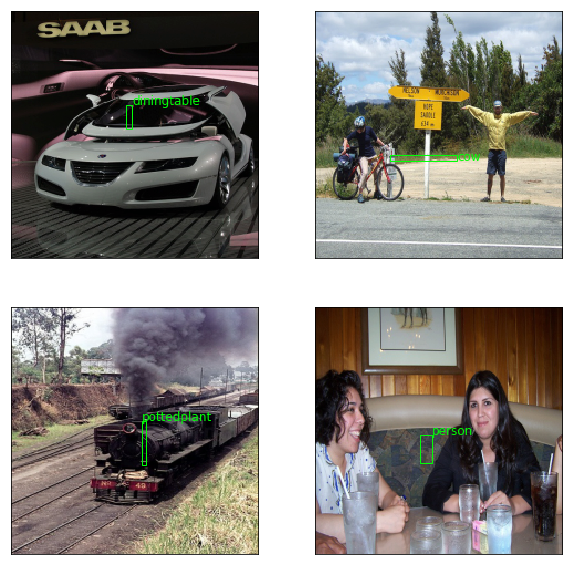

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for image, bb, label, ax in zip(denormed_ims, bb_to_plot, labels_to_plot, axes.reshape(-1)):
    plot_image(image, [bb], [label], ax=ax)
plt.show()